# Методы понижения размерности

## Уменьшение признакового пространства

### Возможны два подхода:
* отбор признаков
* преобразование признаков

## Principal Component Analysis

Метод главных компонент - метод уменьшения размерности данных, который содержит бОльшую часть информации об исходных данных

In [1]:
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt

X = np.random.randint(0, 100, size=(32, 100))
assert X.shape == (32, 100)

X_pca = PCA(n_components=15).fit_transform(X)
assert X_pca.shape == (32, 15)

In [2]:
X.shape

(32, 100)

Сгенерируем небольшую выборку и разберемся на примере, как работает PCA

In [3]:
import seaborn as sns


sns.set_style("dark")
plt.rc('font', size=15)

In [4]:
def draw_points(X, mean=None, arrows=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], s=100, label='data')
    plt.xlim([-5, 10])
    plt.ylim([-3, 12])
    plt.grid()
    
    if mean is not None:
        plt.arrow(*mean, *arrows[0], color='r', width=0.15, label='first component')
        plt.arrow(*mean, *arrows[1], color='g', width=0.15, label='second component')
    
    plt.legend()

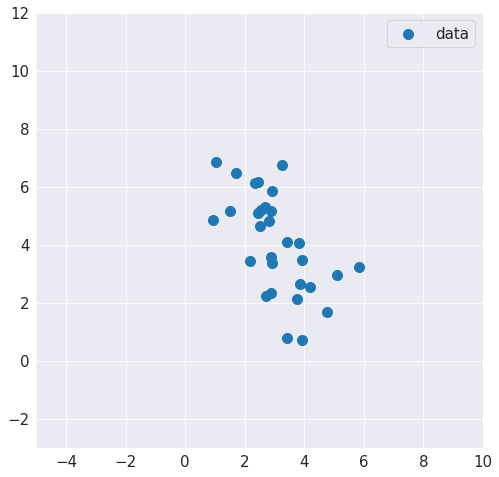

In [5]:
X = np.random.multivariate_normal(mean=[3, 4], cov=[[2, -1.9], [-1.9, 3]], size=30)

draw_points(X)

### Алгоритм PCA можно разбить на шесть этапов:

#### 1. Standardization

Вычитание среднего значения и деление на стандартное отклонение для каждого признака



In [6]:
# в нашем примере не будем делить на стандартное отклонение
X_norm = X - X.mean(axis=0)

#### 2. Covariance matrix computation

Ковариационная матрица представляет собой симметричную матрицу $p×p$ (где $p$ - число признаков), которая содержит ковариации всех пар исходных признаков. Например, для набора данных с 3 признакакми $x$, $y$, $z$ матрица ковариации представляет собой матрицу $3×3$ такого вида:

![kek](https://cdn.builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/Principal%2520Component%2520Analysis%2520Covariance%2520Matrix.png)

где $Cov(X, Y) = \dfrac{1}{n-1} \sum\limits_{i=1}^n \left( x_i - \overline{x} \right) \left( y_i - \overline{y} \right)$,
причём $Cov(X, X) = Var(X)$.

После вычитания среднего в каждом из признаков, у нас $\overline{x} = \overline{y} = \overline{z} = 0$ и матрица ковариации имеет вид $\frac{1}{n-1} X^TX$

In [7]:
cov_matrix = np.cov(X_norm.T)

assert np.allclose(X_norm.T @ X_norm / (X.shape[0] - 1), cov_matrix) 

#### 3. Compute the eigenvectors and eigenvalues of the covariance matrix

PCA находит такие вектора, при проекции на которые дисперсия будет максимальна. Сначала найдём один такой вектор, при котором максимизировалась бы дисперсия проекции нашей выборки на него

![](https://i.stack.imgur.com/Q7HIP.gif)

Можно доказать, что, направление максимальной дисперсии всегда совпадает с собственным вектором матрицы ковариации, имеющим максимальное собственное значение, равное величине этой дисперсии.

Второй вектор считается также, при условии, что он не коррелирован (ортогонален) первому вектору и имеет следующую по величине дисперсию при проекции на него. Такой вектор будет совпадать с собственным вектором матрицы ковариации, имеющим второе по максимальности собственное значение.

И это справедливо также для проекций на большее количество измерений! Дисперсия проекции на $m$-мерное пространство будет максимальна в направлении $m$ собственных векторов матрицы ковариации, имеющих максимальные собственные значения.

Про доказательство этих фактов можно почитать [тут](https://habr.com/ru/post/304214/) и 
[тут](https://math.stackexchange.com/questions/3211467/why-eigenvectors-with-the-highest-eigenvalues-maximize-the-variance-in-pca).

Такие векторы называются главными компонентами.

In [8]:
vals, vecs = np.linalg.eigh(cov_matrix)
vecs = vecs.T # now each row stores eigenvector

order = np.argsort(-1 * vals)
vals, vecs = vals[order], vecs[order]

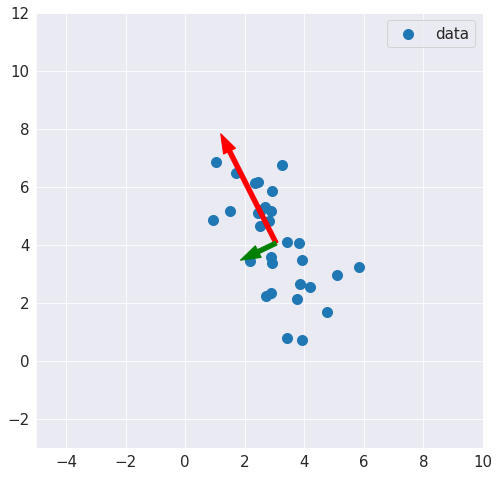

In [9]:
draw_points(X, mean=X.mean(axis=0), arrows=vecs * vals[:, None])

#### 4. Feature matrix

Вычисление собственных векторов и упорядочение их по собственным значениям в порядке убывания позволяет нам найти главные компоненты в порядке значимости. 

На этом этапе мы выбираем, оставить ли все эти компоненты или отбросить те, которые имеют меньшее значение (с низкими собственными значениями), и сформировать с оставшимися матрицу, в столбцах которой записаны собственные векторы, которые мы решили оставить.

Собственные значения показывают количество дисперсии, которая несёт каждая главная компонента.

In [10]:
for i, v in enumerate(vals):
    perc = v / sum(vals) * 100
    print('Percent of information: %.1f' % perc)

Percent of information: 84.2
Percent of information: 15.8


In [11]:
print(
'''
Отбросив второй вектор и спроецировав данные
только на первый, мы потеряем всего %.1f%% информации,
давайте так и сделаем
''' % perc)


Отбросив второй вектор и спроецировав данные
только на первый, мы потеряем всего 15.8% информации,
давайте так и сделаем



In [12]:
vals, vecs = vals[:1], vecs[:1]

#### 5. Dimension reduction (projection)

Осталось спроецировать наши точки на полученные вектора, для этого используем нашу Feature matrix из посчитанных векторов. Собственные вектора из *numpy.linalg.eigh* нормированы и ортогональны, поэтому для для посчёта проекции перемножим скалярно точки с векторами.

In [13]:
proj = X_norm @ vecs.T
# X_norm  [n, old]
# vecs  [new, old]
# X_norm @ vecs.T [n, new]

#### 6. Inverse transform

У нас есть вся необходимая для восстановления данных по оставшимся векторам, а именно координаты базисных векторов в исходном базисе (векторы, на которые мы проецировали) и вектор средних (для отмены центровки).

In [14]:
inverse = proj @ vecs + X.mean(axis=0)

Так как вторую компоненту мы убрали, осталась проекция только на первый вектор.

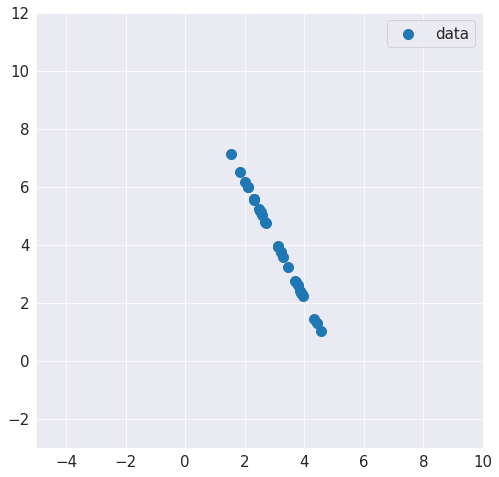

In [15]:
draw_points(inverse)

Убедимся, что найденные значения совпадают с библиотечными

In [16]:
def get_deterministic_vectors(vecs, proj):
    max_abs_cols = np.argmax(np.abs(proj), axis=0)
    signs = np.sign(proj[max_abs_cols, range(proj.shape[1])])
    return vecs * signs[:, None]


X = np.random.randint(0, 100, size=(32, 100))
p = 15

# Standardization
X_norm = X - X.mean(axis=0)

# Covariance matrix computation
cov_matrix = np.cov(X_norm.T)
assert np.allclose(X_norm.T @ X_norm / (X.shape[0] - 1), cov_matrix) 

# Compute the eigenvectors and eigenvalues of the covariance matrix
vals, vecs = np.linalg.eigh(cov_matrix)
vecs = vecs.T # now each row in `vecs` stores eigenvector

order = np.argsort(-1 * vals)
vals, vecs = vals[order], vecs[order]

# Feature matrix
vals, vecs = vals[:p], vecs[:p]

# Dimension reduction (projection)
proj = X_norm @ vecs.T

# PCA from sklearn do this for deterministic solve,
# to compare the results, let's do this too
vecs = get_deterministic_vectors(vecs, proj)
proj = X_norm @ vecs.T

# Inverse transform
inverse = proj @ vecs + X.mean(axis=0)



pca = PCA(n_components=p).fit(X)

assert np.allclose(pca.components_, vecs)
assert np.allclose(pca.explained_variance_, vals)
assert np.allclose(pca.transform(X), proj)
assert np.allclose(pca.inverse_transform(pca.transform(X)), inverse)

In [17]:
pca.components_

array([[ 0.02314378,  0.04268248,  0.06100693, ..., -0.18667328,
        -0.10470229, -0.03104348],
       [ 0.13152701, -0.14092297, -0.00309144, ..., -0.02158435,
        -0.05270677,  0.03532538],
       [-0.01527344,  0.05271759, -0.00664718, ...,  0.12064648,
         0.09908339,  0.02706895],
       ...,
       [ 0.00777414,  0.00695481, -0.15787579, ..., -0.09285726,
         0.03663061,  0.02756241],
       [ 0.01390853,  0.13877144, -0.19270823, ..., -0.07111029,
        -0.10147081,  0.13153965],
       [-0.07497567,  0.04875778,  0.12281346, ..., -0.08746323,
         0.1112728 , -0.15549047]])

Метод главных компонент - метод поиска приближённого признакового пространства меньшей размерности, в котором новые признаки являются линейными комбинациями старых, при этом имея возможность потом восстановиться в исходное пространство.

Но не стоит думать, что всегда всё так хорошо. Надо помнить, что PCA - это линейное преобразование. Поэтому с некоторыми выборками работает плохо:

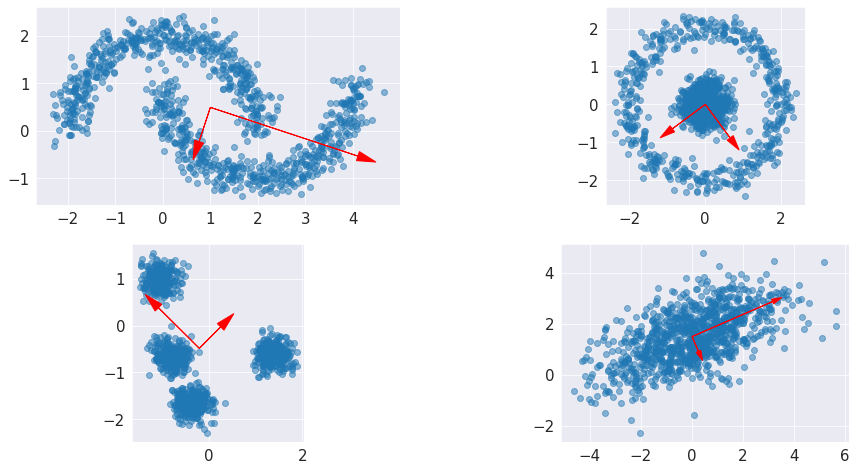

In [18]:
from sklearn.datasets import make_circles, make_moons, make_blobs


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA().fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(*start, *end, head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.grid()
    ax.set_aspect('equal', adjustable='box')

    
np.random.seed(228)
data_synth_bad = [
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(mean=[0, 1.5], cov=[[3, 1], [1, 1]], size=1000),
]


plt.figure(figsize=(16, 8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

Но нам не привыкать, что там где не справляются линейные методы, справится введение ядер!

Вспоминаем: речь идёт о матрице ковариации признаков $X^TX$, то есть вычисляются скалярные произведения. А там, где есть скалярные произведения, можно попробовать их заменить на ядра:

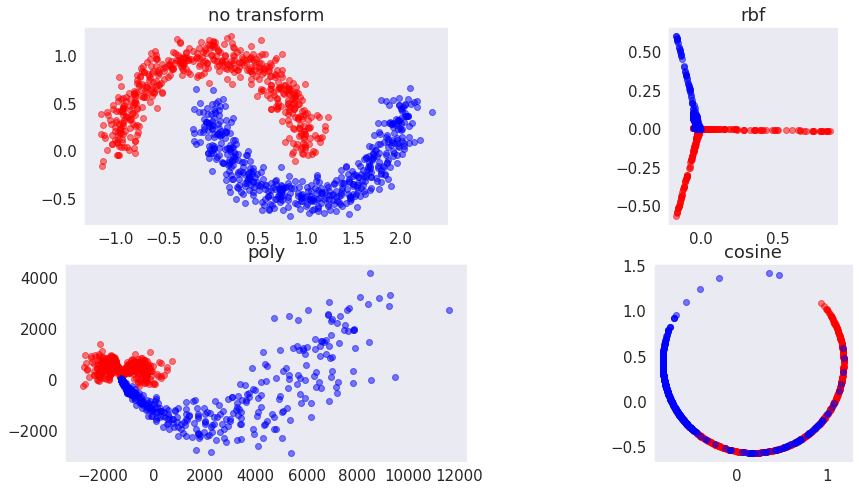

In [19]:
from sklearn.decomposition import KernelPCA


def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(16, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    plt.title('no transform')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=100),
        dict(kernel='poly', gamma=100),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_pca = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.scatter(X_pca[reds, 0], X_pca[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_pca[blues, 0], X_pca[blues, 1], alpha=0.5, c='b')
        plt.title(p['kernel'])
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(228)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

### Лица людей

In [20]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=1000-7)
faces_images = faces.data
faces_ids = faces.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [21]:
faces_images.shape, faces_ids.shape

((400, 4096), (400,))

In [22]:
def show_image(img, image_shape=(64, 64)):
    plt.imshow(img.reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Ниже представлены элементы датасета с лицами людей. Последнее - ''среднее'' лицо

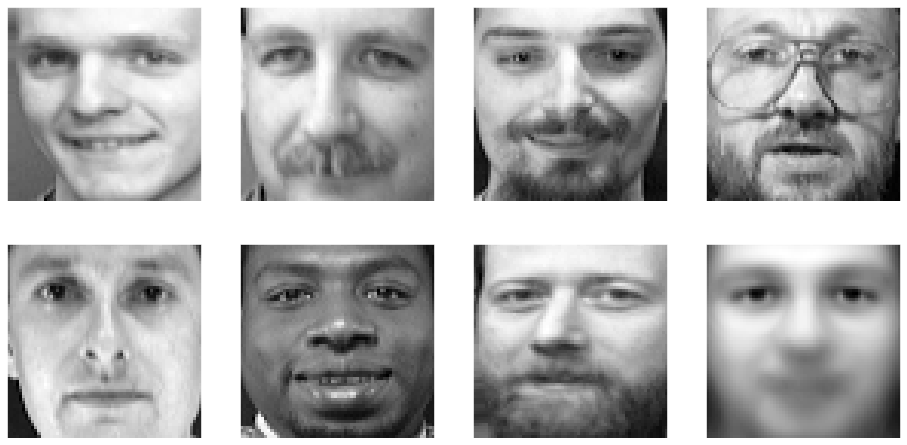

In [23]:
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    img = faces_images[i] if i + 1 != n_samples else mean_face
    show_image(img)

В датасете для одного человека содержиться несколько его фотографий

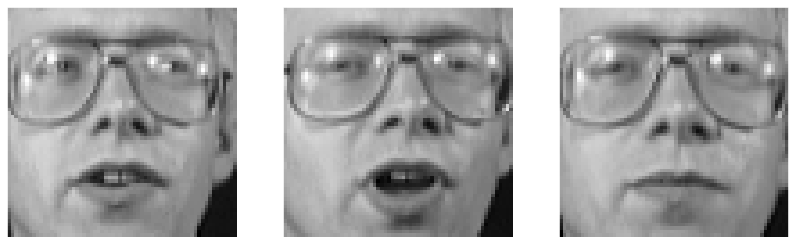

In [24]:
plt.figure(figsize=(14, 7))
for i, idx in enumerate(np.where(faces_ids == 1)[0][:3]):
    plt.subplot(1, 3, i + 1)
    show_image(faces_images[idx])

Что получится если на исходных картинках посчитать PCA? Давайте визуализируем те самые главные компоненты!

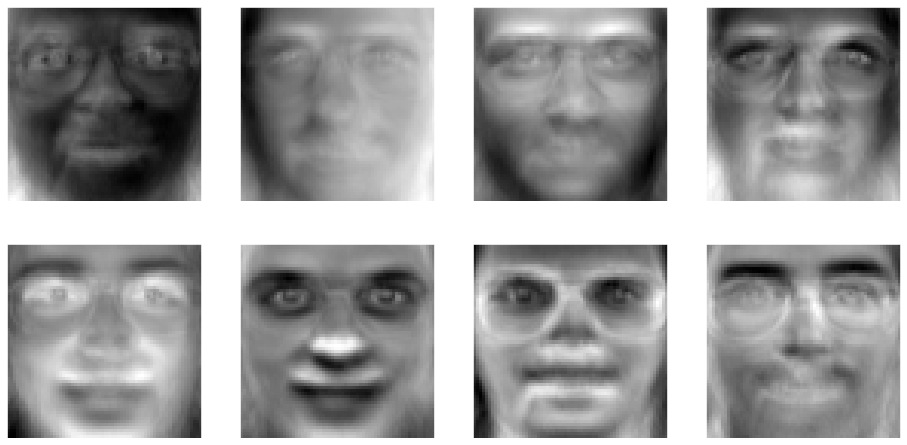

In [25]:
pca = PCA()
pca.fit(faces_images)

plt.figure(figsize=(16, 8))
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    show_image(pca.components_[i])

### Более информативные признаки (для простых моделей)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


gscv_rf = GridSearchCV(
    RandomForestClassifier(),
    {'n_estimators': [50, 100], 'max_depth': [2, 3]}, 
    scoring='accuracy',
    cv=5
)

In [27]:
gscv_rf.fit(faces_images, faces_ids)
print('Accuracy is %.2f' % gscv_rf.best_score_)

Accuracy is 0.57


In [28]:
gscv_rf.fit(pca.transform(faces_images)[:, :100], faces_ids)
print('Accuracy is %.2f' % gscv_rf.best_score_)

Accuracy is 0.75


**Задание 1. (1 балл)**. Так уж выходит, что люди часто любят преобразовывать длинные векторы (в том числе и картинки) в латентные пространства более низкой размерности. Обычно получается, что эти латентные пространства обладают всякими интересными свойствами. Например, в них можно брать линейные комбинации векторов, соответствующих объектам, декодировать и получать объекты похожего толка. Это вам и предлагается сделать!

А именно, напишите функцию, которая будет работать с выборкой лиц. Пускай она принимает на вход два индекса - индексы изображений-лиц из выборки. А на выходе визуализирует ''путешествие'' между этими лицами в латентном пространстве.

Более формально, если у вас есть два изображения $I_1$ и $I_2$, а также методы кодирования $Encode(I)$ и декодирования $Decode(I)$ этих изображений в вектор небольшой размерности (здесь это PCA), можно получить последовательность изображений:
$$
I_j = Decode(\alpha_j Encode(I_1) + (1 -\alpha_j) Encode(I_2)),\ \alpha_j = \frac{j}{k}, j=0,\ldots,k
$$

*Для начала попробуем без PCA*

In [29]:
def w_mean(a, b, alpha):
    return alpha * a + (1 - alpha) * b

def plot_simple_img(faces_images, ind_1, ind_2, k):
    img_1 = faces_images[ind_1].reshape(64, 64)
    img_2 = faces_images[ind_2].reshape(64, 64)

    plt.figure(figsize=(4 * k, 4))

    for i in range(0, k + 1):
        alpha = i / k

        img_res = w_mean(img_1, img_2, alpha)

        plt.subplot(1, k + 1, i + 1)
        plt.title(f'alpha = {alpha:.2f}')
        show_image(img_res)

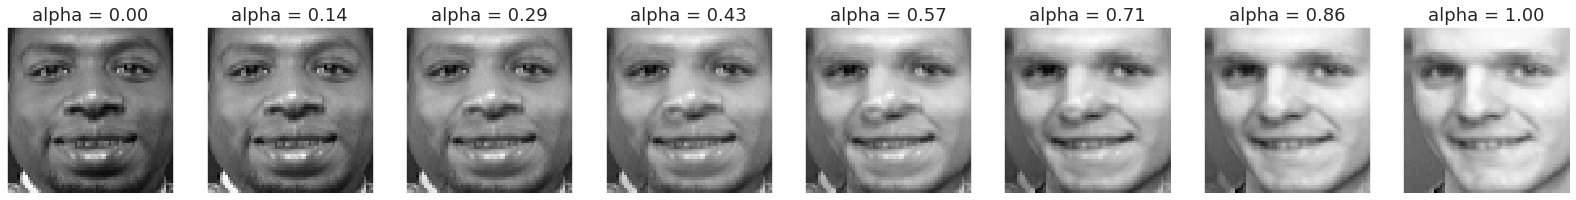

In [30]:
plot_simple_img(faces_images, 0, 5, k=7)

*Теперь с PCA*  
*Обучаем на всех картинках, достаём две закодированные, смешиваем и декодируем результат.*

In [31]:
### YOUR CODE HERE ###

from sklearn.decomposition import PCA

def w_mean(a, b, alpha):
    return alpha * a + (1 - alpha) * b

def plot_best_img(faces_images, ind_1, ind_2, k, n_components=40):
    img_1 = faces_images[ind_1]
    img_2 = faces_images[ind_2]
    
    pca_img = PCA(n_components=n_components)
    pca_img.fit(faces_images)

    img_1_с = pca_img.transform(faces_images)[ind_1]
    img_2_с = pca_img.transform(faces_images)[ind_2]


    plt.figure(figsize=(4 * k, 4))

    for i in range(0, k + 1):
        alpha = i / k

        img_res_с = w_mean(img_1_с, img_2_с, alpha)
        img_res_dc = pca_img.inverse_transform(img_res_с)

        plt.subplot(1, k + 1, i + 1)
        plt.title(f'alpha = {alpha:.2f}')
        show_image(img_res_dc)


*Позапускаем с разным количеством компонент*

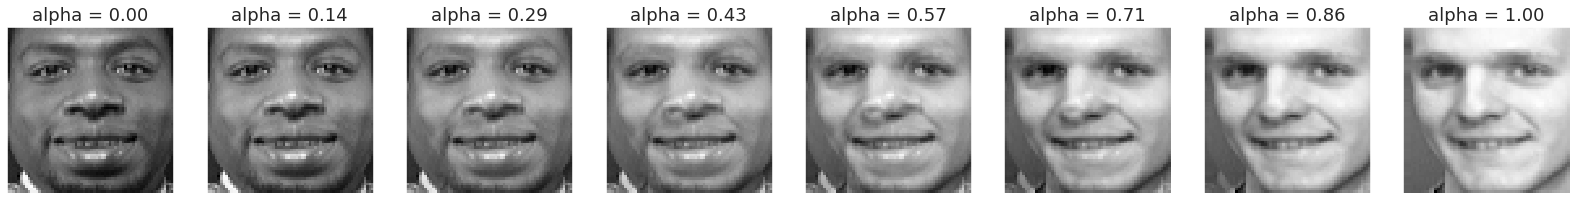

In [32]:
plot_best_img(faces_images, 0, 5, k=7, n_components=400)

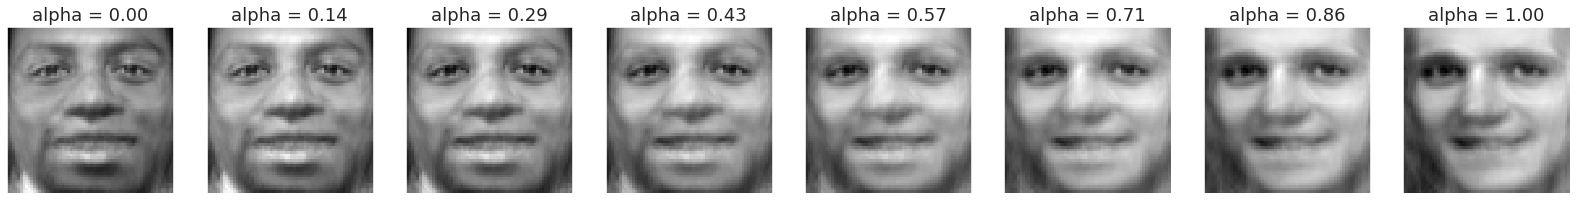

In [33]:
plot_best_img(faces_images, 0, 5, k=7, n_components=50)

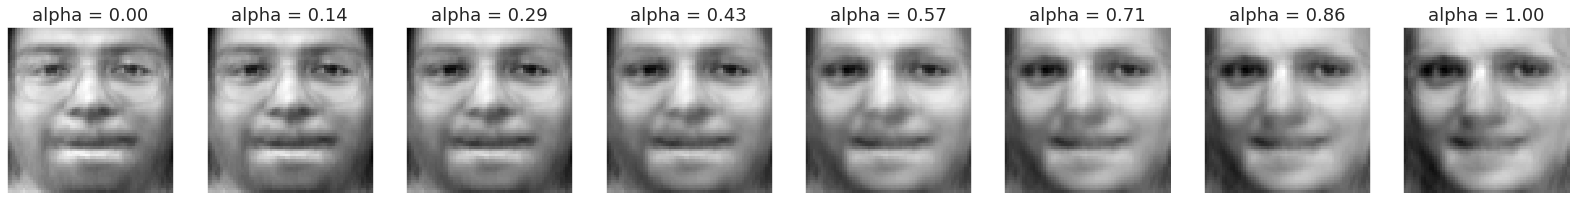

In [34]:
plot_best_img(faces_images, 0, 5, k=7, n_components=20)

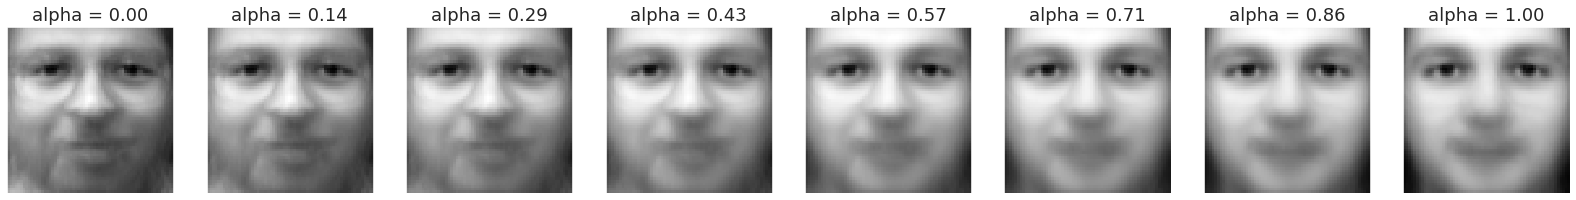

In [35]:
plot_best_img(faces_images, 0, 5, k=7, n_components=1)

### Сжатие данных

Для более наглядного примера загрузим с картинки с хорошим разрешением

In [36]:
!wget https://i.pinimg.com/736x/63/36/fd/6336fd3e5b4a8d0d627426c5b1ac4a42.jpg -O cat.jpg --no-verbose

2021-12-09 17:11:12 URL:https://i.pinimg.com/736x/63/36/fd/6336fd3e5b4a8d0d627426c5b1ac4a42.jpg [145237/145237] -> "cat.jpg" [1]


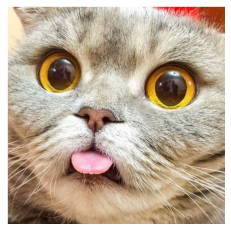

In [37]:
from skimage.io import imread

def show_image_rgb(img):
    plt.imshow(img)
    plt.xticks(())
    plt.yticks(())

img = imread('cat.jpg')[20:550, 100:630]
show_image_rgb(img)

In [38]:
img.shape

(530, 530, 3)

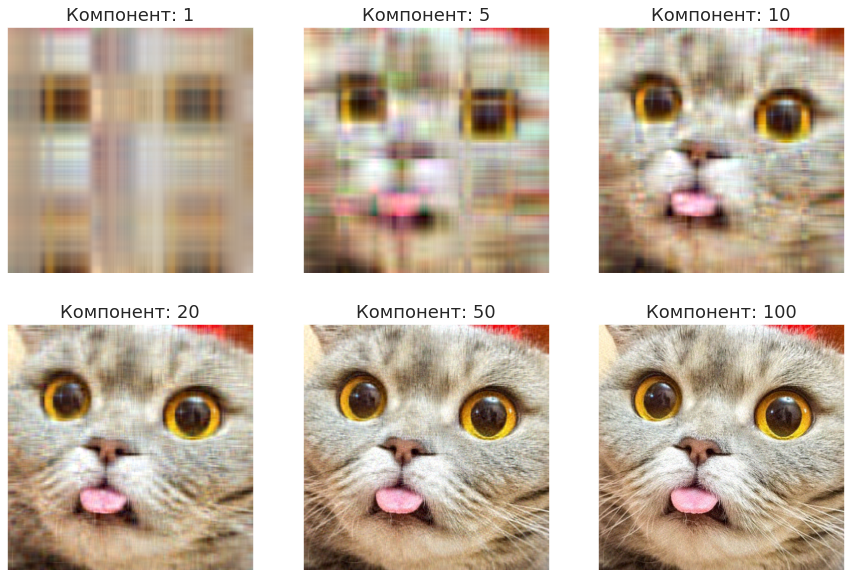

In [39]:
plt.figure(figsize=(15, 10))
for i, p in enumerate([1, 5, 10, 20, 50, 100,]):
    compressed = []
    res = []
    for j in range(0, 3):
        pca = PCA(n_components=p)
        compressed = pca.fit_transform(img[:, :, j])
        decompressed = pca.inverse_transform(compressed)
        res.append(decompressed)
    r = np.dstack(res)
    r = np.array(np.clip(np.round(r), 0, 255), dtype=np.uint8)
    plt.subplot(2, 3, i + 1)
    plt.imshow(r)
    plt.title('Компонент: {}'.format(p))
    plt.xticks(())
    plt.yticks(())

plt.show()

### Полезные ссылки

* https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca - про PCA и его отношение с SVD
* https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579 - прекрасный комментарий-история про PCA (начинается со слов "Imagine a big family dinner, where everybody starts asking you about PCA"), гифка оттуда

## t-SNE

В отличии от PCA, задача t-SNE - это сохранить пространственную структуру данных. Например, это может быть полезно для визуализации.

Идея метода заключается в следующем:

* превратим расстояния между объектами в исходном пространстве в вероятности: 

$$p_{j|i} = \frac{\exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_j) / (2 \sigma_i^2)})}{\sum_{i \neq k} \exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_k) / (2 \sigma_i^2)})}, \quad p_{i|i} = 0,$$

* посчитаем некоторую новую метрику

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

* здесь $\sigma_i$ определяются автоматически для каждого из объектов так, чтобы в областях с высокой плотностью была дисперсия меньше

* теперь определим вероятностное расстояние между точками в новом пространстве:

$$q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j)||^2)^{-1}}{\sum_{k \neq l} (1 + ||\boldsymbol{y}_k - \boldsymbol{y}_l)||^2)^{-1}},$$

* и будем минимизировать разницу между матрицей расстояний в исходном пространстве и в новом:

$$KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

* делать это будем с помощью градиентного спуска

* за подробностями - в оригинальную статью

### Гифка для привлечения внимания к теме

![](https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif)

**Задание 2 (1.5 балла)**. А давайте мы сами тоже получим такую красивую картинку :)
* загрузите датасет с цифрами из sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)
* используйте PCA и t-SNE (https://scikit-learn.org/0.20/modules/generated/sklearn.manifold.TSNE.html) на 64-мерных векторах фичей, чтобы сжать их до размерности 2
* визуализируйте новые объекты на плоскости, причём разные классы отобразите разными цветами
* сравните полученные результаты у t-SNE и PCA

In [40]:
### YOUR CODE HERE ###
from sklearn.datasets import load_digits
digits, labels = load_digits(return_X_y=True)

In [41]:
print(digits.shape)

(1797, 64)


*Начнём с PCA*

In [42]:
from sklearn.decomposition import PCA
pca_digits = PCA(n_components=2)
pca_digits.fit(digits.T)

print(pca_digits.components_.shape)

(2, 1797)


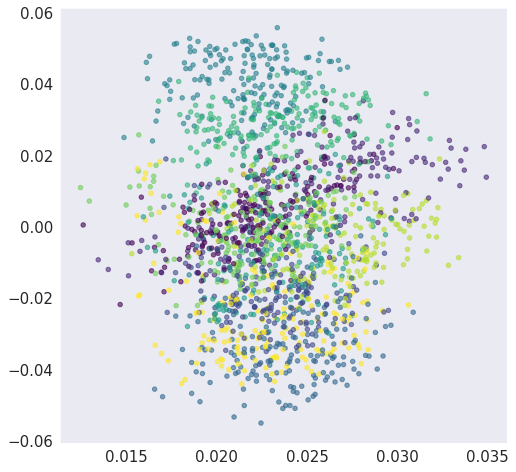

In [43]:
from matplotlib import pyplot as plt

X = pca_digits.components_

plt.figure(figsize=(8, 8))
plt.scatter(X[0], X[1], c=labels, cmap='viridis', s=20, alpha=0.6)

*Теперь t-SNE*

In [44]:
from sklearn.manifold import TSNE

tsne_digits = TSNE(n_components=2, early_exaggeration=12)
tsne_digits.fit(digits)

print(tsne_digits.embedding_.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1797, 2)


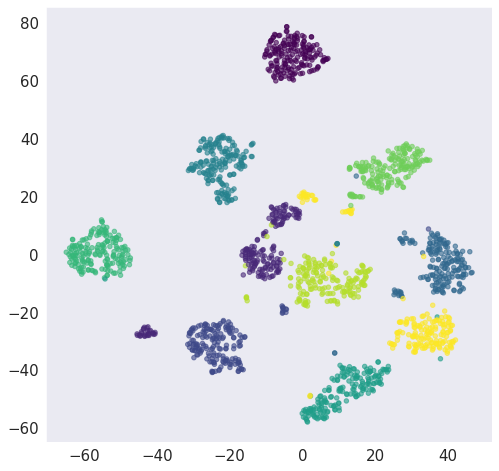

In [45]:
X = tsne_digits.embedding_.T

plt.figure(figsize=(8, 8))
plt.scatter(X[0], X[1], c=labels, cmap='viridis', s=20, alpha=0.6)

plt.show()

*В PCA можно рассмотреть разные области, а в t-SNE прям красота. Чувствую себя волшебником*

Позапускал на разных количествах итераций. Вот, что получилось.

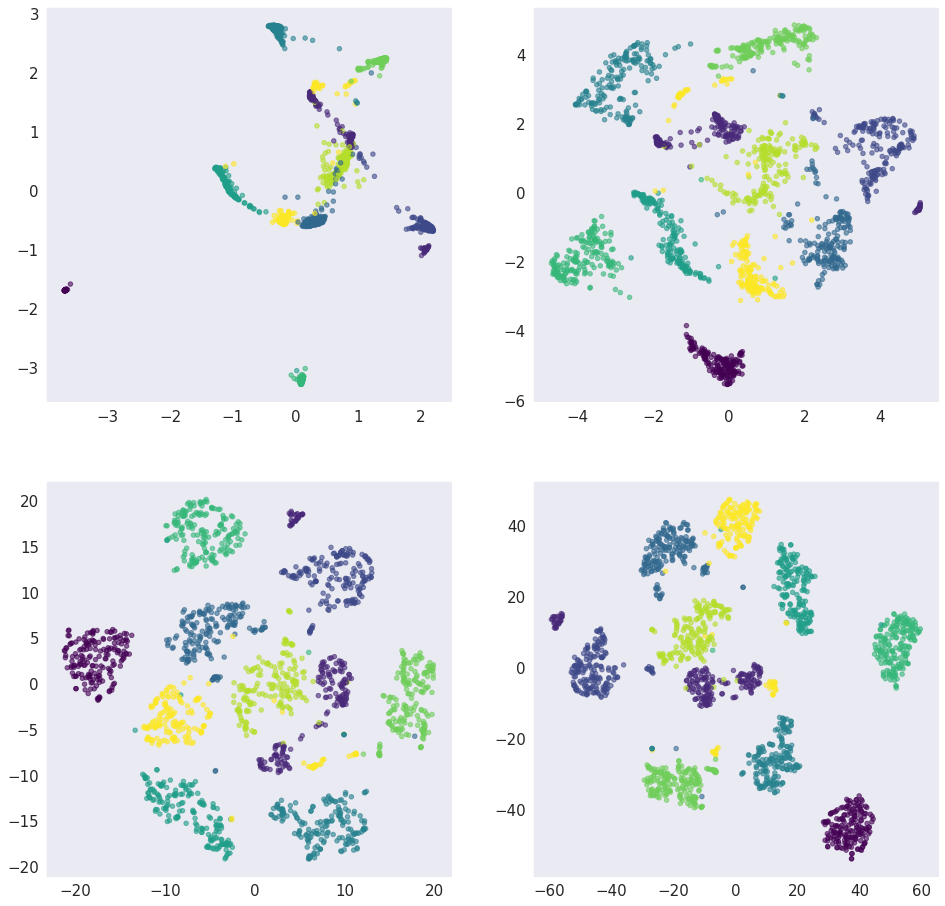

In [46]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(16, 16))

ni_l = [250, 290, 500, 2000]
for i, ni in enumerate(ni_l):
    tsne_digits = TSNE(n_components=2, learning_rate=10, n_iter=ni)
    tsne_digits.fit(digits)

    X = tsne_digits.embedding_.T
    plt.subplot(2, 2, i + 1)
    plt.scatter(X[0], X[1], c=labels, cmap='viridis', s=20, alpha=0.6)

plt.show()

### Полезные ссылки

* http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf - оригинальная статья про t-SNE
* https://lvdmaaten.github.io/tsne/ - гитхаб автора с примерами применения t-SNE для разных данных (и не только)
* https://distill.pub/2016/misread-tsne/ - очень красивая визуализация на тему t-SNE и подбора параметров
* https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm?imm_mid=0d3385&cmp=em-data-na-na-newsltr_20150610 - объяснение t-SNE с картинками (гифка оттуда)

## Другие алгоритмы понижения размерности

### Truncated SVD

* для того, чтобы вся теория в PCA сходилась и можно было применять метод, данные должны быть нормированы, т.е. иметь нулевое среднее (а лучше и единичную дисперсию)
* нормировать, например, разреженные матрицы очень неудобно: они перестают быть разреженными
* Truncated SVD позволяет добиваться того же самого, но без нормировки

### IncrementalPCA

* когда речь заходит об огромном количестве данных, как-то пользоваться алгоритмами примерно кубической сложности (каким является PCA) не очень удобно
* но существуют методы, которые умеют принимать выборку небольшими кусочками и их сложность зависит не от объёма всей выборки, а от объёма кусочка
* таким алгоритмом, например, является IncrementalIPCA

https://www.kaggle.com/shivamb/dataset-decomposition-techniques - про разные схемы понижения размерности на примере одного kaggle-соревнования

# Многоклассовая классификация

Иногда в жизни нужно решать задачу многоклассовой классификации:
* классификация цифр
* классификация лиц
* классификаия животных на изображениях
* классификация видов растений

Но есть и **мульти**классовая классификация:
* многоклассовая - это предсказать одну метку для каждого объекта
* мультиклассовая - это предсказать много меток для каждого объекта

Как правило, есть 3 варианта:
* взять бинарный классификатор и сделать One vs. One
* взять бинарный классификатор и сделать One vs. Rest
* обобщить методы бинарной классификации на бОльшие размерности

Разберёмся с последним:
* kNN плевать на то, сколько классов
* решающим деревьям тоже
* а вот с линейными методами чуть сложнее

Двухклассовая классификация:
* $$
			a(x) = sign\langle w, x\rangle
$$

Многоклассовая классификация:
* $$
			a(x) =  \arg\max\limits_{k\in \{1, \ldots, K\}} \langle w_k, x\rangle 
$$

## One vs. One

![](https://i.imgur.com/NreKSdj.png)

## One vs. Rest

![](https://i.imgur.com/zZ8Ey32.png)

Сгенерируем небольшую выборку данных для трёхклассовой классификации:

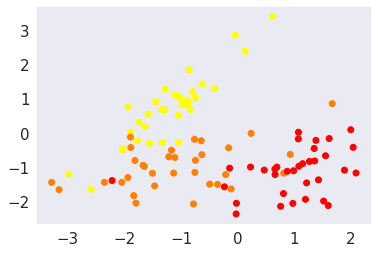

In [47]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_classes=3, n_informative=2,
                           n_redundant=0, n_repeated=0, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.show()

**Задание 3 (1.5 балла).** Давайте сравним методы (One vs. One) vs. (One vs. Rest). Используя логистическую регрессию и соответствующие методы из sklearn (https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsOneClassifier.html#sklearn.multiclass.OneVsOneClassifier и https://scikit-learn.org/0.20/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), численно, нарисовав confusion matrix (https://scikit-learn.org/0.20/modules/generated/sklearn.metrics.confusion_matrix.html) для того, чтобы определить, какие классы чаще всего смешиваются в каждом из методов.

In [48]:
### YOUR CODE HERE ###

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [49]:
def classifier_confusion_matrix(estimator, strategy, X, y):
    model = strategy(estimator)
    model.fit(X, y)
    pred_y = model.predict(X)
    return confusion_matrix(y, pred_y)

In [50]:
print('OVO:\n{}'.format(classifier_confusion_matrix(LogisticRegression(), OneVsOneClassifier, X, y)))
print('OVR:\n{}'.format(classifier_confusion_matrix(LogisticRegression(), OneVsRestClassifier, X, y)))

OVO:
[[32  2  0]
 [ 4 27  2]
 [ 0  4 29]]
OVR:
[[33  1  0]
 [ 6 23  4]
 [ 0  2 31]]


*Теперь построим графики*

In [51]:
xx, yy = np.array(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)))
xx = xx.reshape(50 ** 2)
yy = yy.reshape(50 ** 2)

grid = np.concatenate((xx[:, np.newaxis], yy[:, np.newaxis]), axis=1)

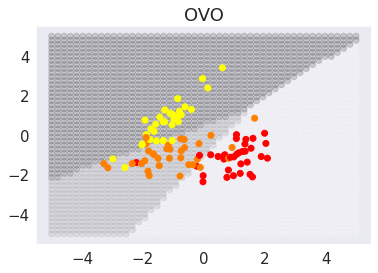

In [52]:
model_ovo = OneVsOneClassifier(LogisticRegression())
model_ovo.fit(X, y)
pred_y_ovo = model_ovo.predict(grid)

plt.title('OVO')
plt.scatter(grid[:, 0], grid[:, 1], c=pred_y_ovo, cmap='gray_r', alpha=0.15)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.show()

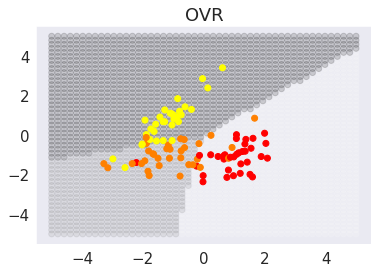

In [53]:
model_ovr = OneVsRestClassifier(LogisticRegression())
model_ovr.fit(X, y)
pred_y_ovr = model_ovr.predict(grid)

plt.title('OVR')
plt.scatter(grid[:, 0], grid[:, 1], c=pred_y_ovr, cmap='gray_r', alpha=0.15)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.show()